In [ ]:
'''
Link dataset:
https://www.kaggle.com/c/vinbigdata-chest-xray-abnormalities-detection
https://www.kaggle.com/sreevishnudamodaran/effdet-latestvinbigdata-wbf-fused
https://www.kaggle.com/awsaf49/vinbigdata-original-image-dataset
'''

# Set up

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
!pip install pycocotools>=2.0.2

In [ ]:
!pip install timm>=0.3.2

In [ ]:
!pip install omegaconf>=2.0

In [ ]:
!pip install ensemble-boxes

In [ ]:
! pip install albumentations==0.4.6

     |████████████████████████████████| 122kB 13.4MB/s 
     |████████████████████████████████| 952kB 20.2MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp37-none-any.whl size=65163 sha256=d8b2caa145159cfc86888cf700b4363fb91dd62a7207b0ac357bd4de94d84152
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
!pip install effdet

     |████████████████████████████████| 112kB 14.2MB/s 


In [ ]:
import sys
import torch
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from glob import glob
import warnings
from collections import Counter

from ensemble_boxes import weighted_boxes_fusion
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.utils.data.dataloader import default_collate

from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet
from effdet import create_model, unwrap_bench, create_loader, create_dataset, create_evaluator, create_model_from_config
from effdet.data import resolve_input_config, SkipSubset
from effdet.anchors import Anchors, AnchorLabeler
from timm.models import resume_checkpoint, load_checkpoint
from timm.utils import *
from timm.optim import create_optimizer
from timm.scheduler import create_scheduler

In [ ]:
SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(SEED)

In [ ]:
!mkdir working

In [ ]:
!cp '/content/drive/MyDrive/effDet/train.csv' '/content/working/train.csv'

In [ ]:
!cp '/content/drive/MyDrive/effDet/VinBigData Original Image Dataset.zip' '/content/working/VinBigData Original Image Dataset.zip'

In [ ]:
!unzip '/content/working/VinBigData Original Image Dataset.zip' -d '/content/working/vinbigdata-original-image-dataset'

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: /content/working/vinbigdata-original-image-dataset/vinbigdata/train/a9f2816d377349f221a96f46c728d36e.jpg  
  inflating: /content/working/vinbigdata-original-image-dataset/vinbigdata/train/a9f32aee073a0ee7ea94e959ab63885c.jpg  
  inflating: /content/working/vinbigdata-original-image-dataset/vinbigdata/train/a9f467688d104d27583ea3b3154b1f30.jpg  
  inflating: /content/working/vinbigdata-original-image-dataset/vinbigdata/train/a9f4c9a4971b3877981e09d4a2ac7fc0.jpg  
  inflating: /content/working/vinbigdata-original-image-dataset/vinbigdata/train/a9f60e50925ece0b5c00b6bbd9f0825c.jpg  
  inflating: /content/working/vinbigdata-original-image-dataset/vinbigdata/train/aa0202259a3cba71d0e72468e2d9c3e2.jpg  
  inflating: /content/working/vinbigdata-original-image-dataset/vinbigdata/train/aa08370eb6114a474adfd0accb6a7238.jpg  
  inflating: /content/working/vinbigdata-original-image-dataset/vinbigdata/train/aa0a24df022cd97cc1dff4

In [ ]:
!cp '/content/drive/MyDrive/effDet/EffDet 0.2.3 Latest + VinBigData WBF Fused.zip' '/content/working/EffDet 0.2.3 Latest + VinBigData WBF Fused.zip'

In [ ]:
!unzip '/content/working/EffDet 0.2.3 Latest + VinBigData WBF Fused.zip' -d '/content/working/effdet-latestvinbigdata-wbf-fused'

Archive:  /content/working/EffDet 0.2.3 Latest + VinBigData WBF Fused.zip
  inflating: /content/working/effdet-latestvinbigdata-wbf-fused/efficientdet-pytorch/.git/HEAD  
  inflating: /content/working/effdet-latestvinbigdata-wbf-fused/efficientdet-pytorch/.git/config  
  inflating: /content/working/effdet-latestvinbigdata-wbf-fused/efficientdet-pytorch/.git/description  
  inflating: /content/working/effdet-latestvinbigdata-wbf-fused/efficientdet-pytorch/.git/hooks/applypatch-msg.sample  
  inflating: /content/working/effdet-latestvinbigdata-wbf-fused/efficientdet-pytorch/.git/hooks/commit-msg.sample  
  inflating: /content/working/effdet-latestvinbigdata-wbf-fused/efficientdet-pytorch/.git/hooks/fsmonitor-watchman.sample  
  inflating: /content/working/effdet-latestvinbigdata-wbf-fused/efficientdet-pytorch/.git/hooks/post-update.sample  
  inflating: /content/working/effdet-latestvinbigdata-wbf-fused/efficientdet-pytorch/.git/hooks/pre-applypatch.sample  
  inflating: /content/working

# Get data

In [ ]:
df_annotations = pd.read_csv('/content/working/train.csv')
df_annotations = df_annotations[df_annotations['class_id']!=14].reset_index(drop=True)
df_annotations['image_path'] = df_annotations['image_id'].map(lambda x:os.path.join('/content/working/vinbigdata-original-image-dataset/vinbigdata/train',
                                                                                    str(x)+'.jpg'))
df_annotations.sample(5)

image_id  ...                                         image_path
2960   e62c07fde352cc658af3f989fe0b546f  ...  /content/working/vinbigdata-original-image-dat...
18611  515fa6a2f756494eb4b19d7248989268  ...  /content/working/vinbigdata-original-image-dat...
9640   5b914f255801a14edc598bbe7f480f20  ...  /content/working/vinbigdata-original-image-dat...
13544  4b56bc6d22b192f075f13231419dfcc8  ...  /content/working/vinbigdata-original-image-dat...
10240  cd33be932bca447f6bf5b83b03018806  ...  /content/working/vinbigdata-original-image-dat...

[5 rows x 9 columns]

In [ ]:
df_annotations_wbf = pd.read_csv('/content/working/effdet-latestvinbigdata-wbf-fused/train_wbf_original.csv', index_col='Unnamed: 0')
df_annotations_wbf['image_path'] = df_annotations['image_path']
#For Testing
# df_annotations_wbf = df_annotations_wbf.head(18000)

df_annotations_wbf.sample(5)

image_id          class_name  ...  width  height
4366   7bd83b3d3af0ea8150c8f2a737712db1        Lung_Opacity  ...   3193    2804
12322  4bd71829299b65b9ba7a01ce24387427    Pleural_effusion  ...   2670    2787
9817   765760a9e2d3b82da72ca1ab86229b79       Consolidation  ...   2721    2409
12173  cf412a6f906091434c19ffd30f2df9b6  Pulmonary_fibrosis  ...   2448    1984
3111   3cac0eba7aff674db58e5e7d5cebe985        Lung_Opacity  ...   3073    2691

[5 rows x 10 columns]

In [ ]:
len(os.listdir('/content/working/vinbigdata-original-image-dataset/vinbigdata/train'))

15000

# Visualize Original vs Fused

## Helper function

In [ ]:
label2color = [[59, 238, 119], [222, 21, 229], [94, 49, 164], [206, 221, 133], [117, 75, 3],
                 [210, 224, 119], [211, 176, 166], [63, 7, 197], [102, 65, 77], [194, 134, 175],
                 [209, 219, 50], [255, 44, 47], [89, 125, 149], [110, 27, 100]]

viz_labels =  ["Aortic_enlargement", "Atelectasis", "Calcification", "Cardiomegaly",
            "Consolidation", "ILD", "Infiltration", "Lung_Opacity", "Nodule/Mass",
            "Other_lesion", "Pleural_effusion", "Pleural_thickening", "Pneumothorax",
            "Pulmonary_fibrosis"]

def plot_img(img, size=(18, 18), is_rgb=True, title="", cmap=None):
    plt.figure(figsize=size)
    plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()

def plot_imgs(imgs, cols=2, size=10, is_rgb=True, title="", cmap=None, img_size=None):
    rows = len(imgs)//cols + 1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, img in enumerate(imgs):
        if img_size is not None:
            img = cv2.resize(img, img_size)
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    return fig
    
def draw_bbox(image, box, label, color):   
    alpha = 0.4
    alpha_font = 0.6
    thickness = 4
    font_size = 2.0
    font_weight = 2
    overlay_bbox = image.copy()
    overlay_text = image.copy()
    output = image.copy()

    text_width, text_height = cv2.getTextSize(label.upper(), cv2.FONT_HERSHEY_SIMPLEX, font_size, font_weight)[0]
    cv2.rectangle(overlay_bbox, (box[0], box[1]), (box[2], box[3]),
                color, -1)
    cv2.addWeighted(overlay_bbox, alpha, output, 1 - alpha, 0, output)
    cv2.rectangle(overlay_text, (box[0], box[1]-18-text_height), (box[0]+text_width+8, box[1]),
                (0, 0, 0), -1)
    cv2.addWeighted(overlay_text, alpha_font, output, 1 - alpha_font, 0, output)
    cv2.rectangle(output, (box[0], box[1]), (box[2], box[3]),
                    color, thickness)
    cv2.putText(output, label.upper(), (box[0], box[1]-12),
            cv2.FONT_HERSHEY_SIMPLEX, font_size, (255, 255, 255), font_weight, cv2.LINE_AA)
    return output

def draw_bbox_small(image, box, label, color):   
    alpha = 0.4
    alpha_text = 0.4
    thickness = 1
    font_size = 0.4
    overlay_bbox = image.copy()
    overlay_text = image.copy()
    output = image.copy()

    text_width, text_height = cv2.getTextSize(label.upper(), cv2.FONT_HERSHEY_SIMPLEX, font_size, thickness)[0]
    cv2.rectangle(overlay_bbox, (box[0], box[1]), (box[2], box[3]),
                color, -1)
    cv2.addWeighted(overlay_bbox, alpha, output, 1 - alpha, 0, output)
    cv2.rectangle(overlay_text, (box[0], box[1]-7-text_height), (box[0]+text_width+2, box[1]),
                (0, 0, 0), -1)
    cv2.addWeighted(overlay_text, alpha_text, output, 1 - alpha_text, 0, output)
    cv2.rectangle(output, (box[0], box[1]), (box[2], box[3]),
                    color, thickness)
    cv2.putText(output, label.upper(), (box[0], box[1]-5),
            cv2.FONT_HERSHEY_SIMPLEX, font_size, (255, 255, 255), thickness, cv2.LINE_AA)
    return output

/content/working/vinbigdata-original-image-dataset/vinbigdata/train/9a5094b2563a1ef3ff50dc5c7ff71345.jpg
Bboxes before WBF:
 [[691.0, 1375.0, 1653.0, 1831.0], [1789.0, 1729.0, 1875.0, 1992.0], [1789.0, 1729.0, 1875.0, 1992.0], [692.0, 1375.0, 1657.0, 1799.0], [689.0, 1313.0, 1666.0, 1763.0], [1052.0, 715.0, 1299.0, 966.0]]
Labels before WBF:
 [3, 10, 11, 3, 3, 0]
Bboxes after WBF:
 [[690.7, 1354.3, 1658.7, 1797.7], [1789.0, 1729.0, 1875.0, 1992.0], [1789.0, 1729.0, 1875.0, 1992.0], [1052.0, 715.0, 1299.0, 966.0]]
Labels after WBF:
 [3, 10, 11, 0]

/content/working/vinbigdata-original-image-dataset/vinbigdata/train/051132a778e61a86eb147c7c6f564dfe.jpg
Bboxes before WBF:
 [[1264.0, 743.0, 1611.0, 1019.0], [1305.0, 731.0, 1613.0, 1066.0], [948.0, 1267.0, 2063.0, 1672.0], [962.0, 1331.0, 2035.0, 1624.0], [1592.0, 452.0, 1804.0, 604.0], [1275.0, 729.0, 1612.0, 1066.0], [952.0, 1317.0, 2033.0, 1723.0]]
Labels before WBF:
 [0, 0, 3, 3, 11, 0, 3]
Bboxes after WBF:
 [[954.0, 1305.0, 2043.7, 167

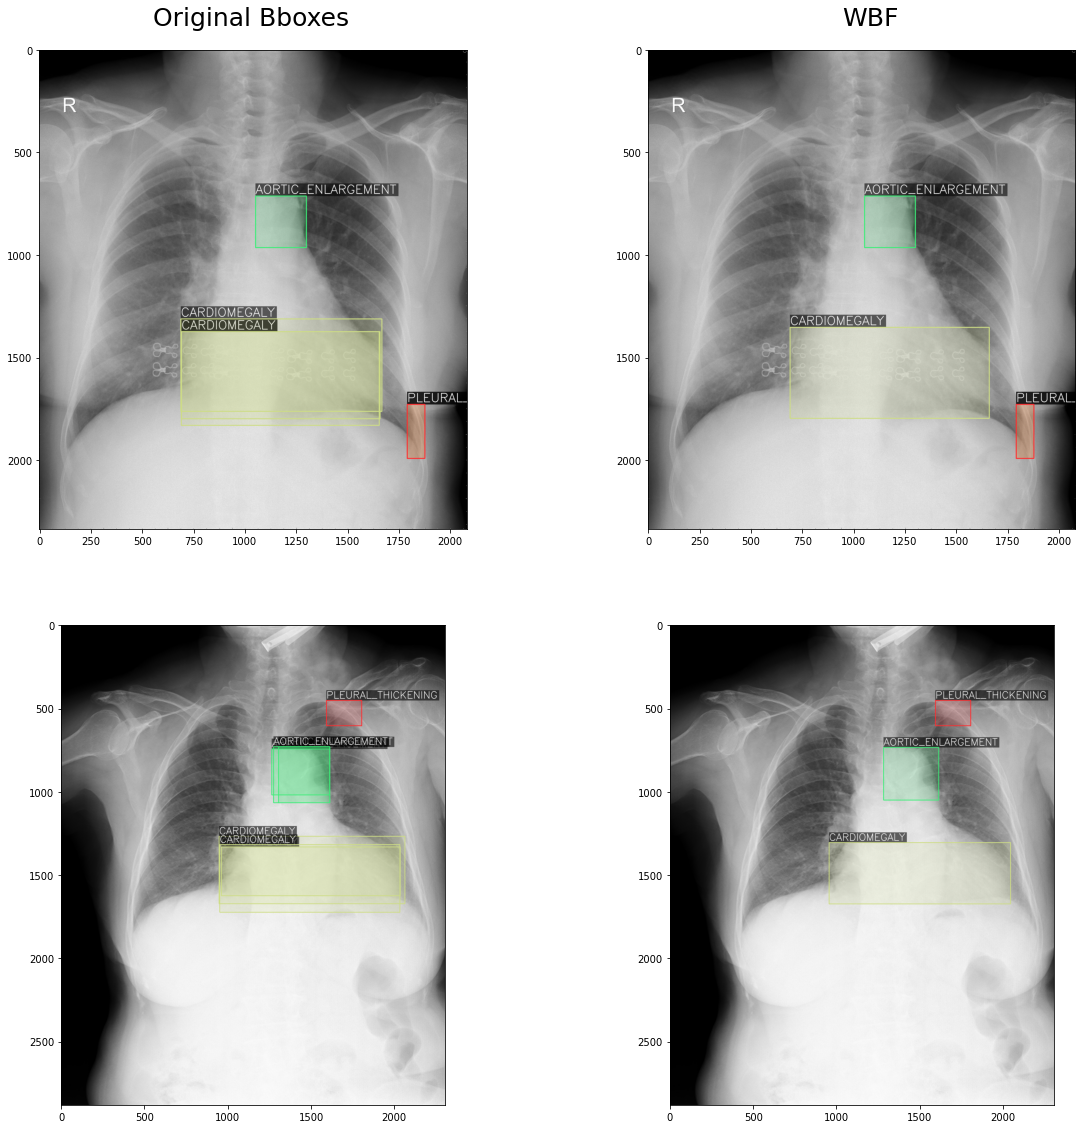

In [ ]:
viz_images = []

for img_id in df_annotations_wbf['image_id'].unique()[:2]:
    img_path = df_annotations[df_annotations.image_id==img_id]['image_path'].iloc[0]
    print(img_path)
    img_array  = cv2.imread(img_path)

    img_annotations = df_annotations[df_annotations.image_id==img_id]
    boxes_actual = img_annotations[['x_min', 'y_min', 'x_max', 'y_max']].to_numpy().tolist()
    labels_actual = img_annotations['class_id'].to_numpy().tolist()
    
    img_annotations_wbf = df_annotations_wbf[df_annotations_wbf.image_id==img_id]
    boxes_wbf = img_annotations_wbf[['x_min', 'y_min', 'x_max', 'y_max']].to_numpy().tolist()
    box_labels_wbf = img_annotations_wbf['class_id'].to_numpy().tolist()
    
    print("Bboxes before WBF:\n", boxes_actual)
    print("Labels before WBF:\n", labels_actual)
    
    ## Visualize Original Bboxes
    img_before = img_array.copy()
    for box, label in zip(boxes_actual, labels_actual):
        # x_min, y_min, x_max, y_max = (box[0], box[1], box[2], box[3])
        color = label2color[int(label)]
        img_before = draw_bbox(img_before, list(np.int_(box)), viz_labels[label], color)
    viz_images.append(img_before)

    print("Bboxes after WBF:\n", boxes_wbf)
    print("Labels after WBF:\n", box_labels_wbf)
    
    ## Visualize Bboxes after operation
    img_after = img_array.copy()
    for box, label in zip(boxes_wbf, box_labels_wbf):
        color = label2color[int(label)]
        img_after = draw_bbox(img_after, list(np.int_(box)), viz_labels[label], color)
    viz_images.append(img_after)
    print()
        
plot_imgs(viz_images, cmap=None)
plt.figtext(0.3, 0.9,"Original Bboxes", va="top", ha="center", size=25)
plt.figtext(0.73, 0.9,"WBF", va="top", ha="center", size=25)
plt.savefig('wbf.png', bbox_inches='tight')
plt.show()

# Augmentations & Transforms

In [ ]:
def get_train_transforms():
    return A.Compose(
        A.OneOf([
            A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                 val_shift_limit=0.2, p=0.9),
            A.RandomBrightnessContrast(brightness_limit=0.2, 
                                       contrast_limit=0.2, p=0.9),
        ],p=0.9),
        A.JpegCompression(quality_lower=85, quality_upper=95, p=0.2),
        A.OneOf([
            A.Blur(blur_limit=3, p=1.0),
            A.MedianBlur(blur_limit=3, p=1.0)
            ],p=0.1),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Transpose(p=0.5),
        A.Resize(height=512, width=512, p=1),
        A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
        ToTensorV2(p=1.0)
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

# Dataset Retrieval and Pre-processsing

In [ ]:
TRAIN_ROOT_PATH = '/content/working/vinbigdata-original-image-dataset/vinbigdata/train'

class DatasetRetriever(Dataset):

    def __init__(self, marking, image_ids, transforms=None, test=False):
        super().__init__()
        self.image_ids = image_ids
        self.marking = marking
        self.transforms = transforms
        self.test = test
        
    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        
        image, boxes, labels = self.load_image_and_boxes(index)
        
        if self.test or random.random() > 0.33:
            image, boxes, labels = self.load_image_and_boxes(index)
        elif random.random() > 0.5:
            image, boxes, labels = self.load_cutmix_image_and_boxes(index)
        else:
            image, boxes, labels = self.load_mixup_image_and_boxes(index)
        
        ## To prevent ValueError: y_max is less than or equal to y_min for bbox from albumentations bbox_utils
        labels = np.array(labels, dtype=np.int).reshape(len(labels), 1)
        combined = np.hstack((boxes.astype(np.int), labels))
        combined = combined[np.logical_and(combined[:,2] > combined[:,0],
                                                          combined[:,3] > combined[:,1])]
        boxes = combined[:, :4]
        labels = combined[:, 4].tolist()
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = torch.tensor(labels)
        target['image_id'] = torch.tensor([index])
        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  ## ymin, xmin, ymax, xmax
                    break
            
            ## Handling case where no valid bboxes are present
            if len(target['boxes'])==0 or i==9:
                return None
            else:
                ## Handling case where augmentation and tensor conversion yields no valid annotations
                try:
                    assert torch.is_tensor(image), f"Invalid image type:{type(image)}"
                    assert torch.is_tensor(target['boxes']), f"Invalid target type:{type(target['boxes'])}"
                except Exception as E:
                    print("Image skipped:", E)
                    return None      

        return image, target, image_id

    def __len__(self):
        return self.image_ids.shape[0]
    
    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
#         print(f'{TRAIN_ROOT_PATH}/{image_id}.jpg')
        image = cv2.imread(f'{TRAIN_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR).copy()
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        records = self.marking[self.marking['image_id'] == image_id]
        boxes = records[['x_min', 'y_min', 'x_max', 'y_max']].values
        labels = records['class_id'].tolist()
        resize_transform = A.Compose([A.Resize(height=512, width=512, p=1.0)], 
                                    p=1.0, 
                                    bbox_params=A.BboxParams(
                                        format='pascal_voc',
                                        min_area=0.1, 
                                        min_visibility=0.1,
                                        label_fields=['labels'])
                                    )

        resized = resize_transform(**{
                'image': image,
                'bboxes': boxes,
                'labels': labels
            })

        resized_bboxes = np.vstack((list(bx) for bx in resized['bboxes']))
        return resized['image'], resized_bboxes, resized['labels']
    
    def load_mixup_image_and_boxes(self, index):
        image, boxes, labels = self.load_image_and_boxes(index)
        r_image, r_boxes, r_labels = self.load_image_and_boxes(random.randint(0, self.image_ids.shape[0] - 1))
        return (image+r_image)/2, np.vstack((boxes, r_boxes)).astype(np.int32), np.concatenate((labels, r_labels))

    def load_cutmix_image_and_boxes(self, index, imsize=512):
        """ 
        This implementation of cutmix author:  https://www.kaggle.com/nvnnghia 
        Refactoring and adaptation: https://www.kaggle.com/shonenkov
        """
        w, h = imsize, imsize
        s = imsize // 2
    
        xc, yc = [int(random.uniform(imsize * 0.25, imsize * 0.75)) for _ in range(2)]  # center x, y
        indexes = [index] + [random.randint(0, self.image_ids.shape[0] - 1) for _ in range(3)]

        result_image = np.full((imsize, imsize, 3), 1, dtype=np.float32)
        result_boxes = []
        result_labels = np.array([], dtype=np.int)

        for i, index in enumerate(indexes):
            image, boxes, labels = self.load_image_and_boxes(index)
            if i == 0:
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)
            result_image[y1a:y2a, x1a:x2a] = image[y1b:y2b, x1b:x2b]
            padw = x1a - x1b
            padh = y1a - y1b

            boxes[:, 0] += padw
            boxes[:, 1] += padh
            boxes[:, 2] += padw
            boxes[:, 3] += padh

            result_boxes.append(boxes)
            result_labels = np.concatenate((result_labels, labels))

        result_boxes = np.concatenate(result_boxes, 0)
        np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
        result_boxes = result_boxes.astype(np.int32)
        index_to_use = np.where((result_boxes[:,2]-result_boxes[:,0])*(result_boxes[:,3]-result_boxes[:,1]) > 0)
        result_boxes = result_boxes[index_to_use]
        result_labels = result_labels[index_to_use]
        
        return result_image, result_boxes, result_labels

# MixUp Techniques

findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


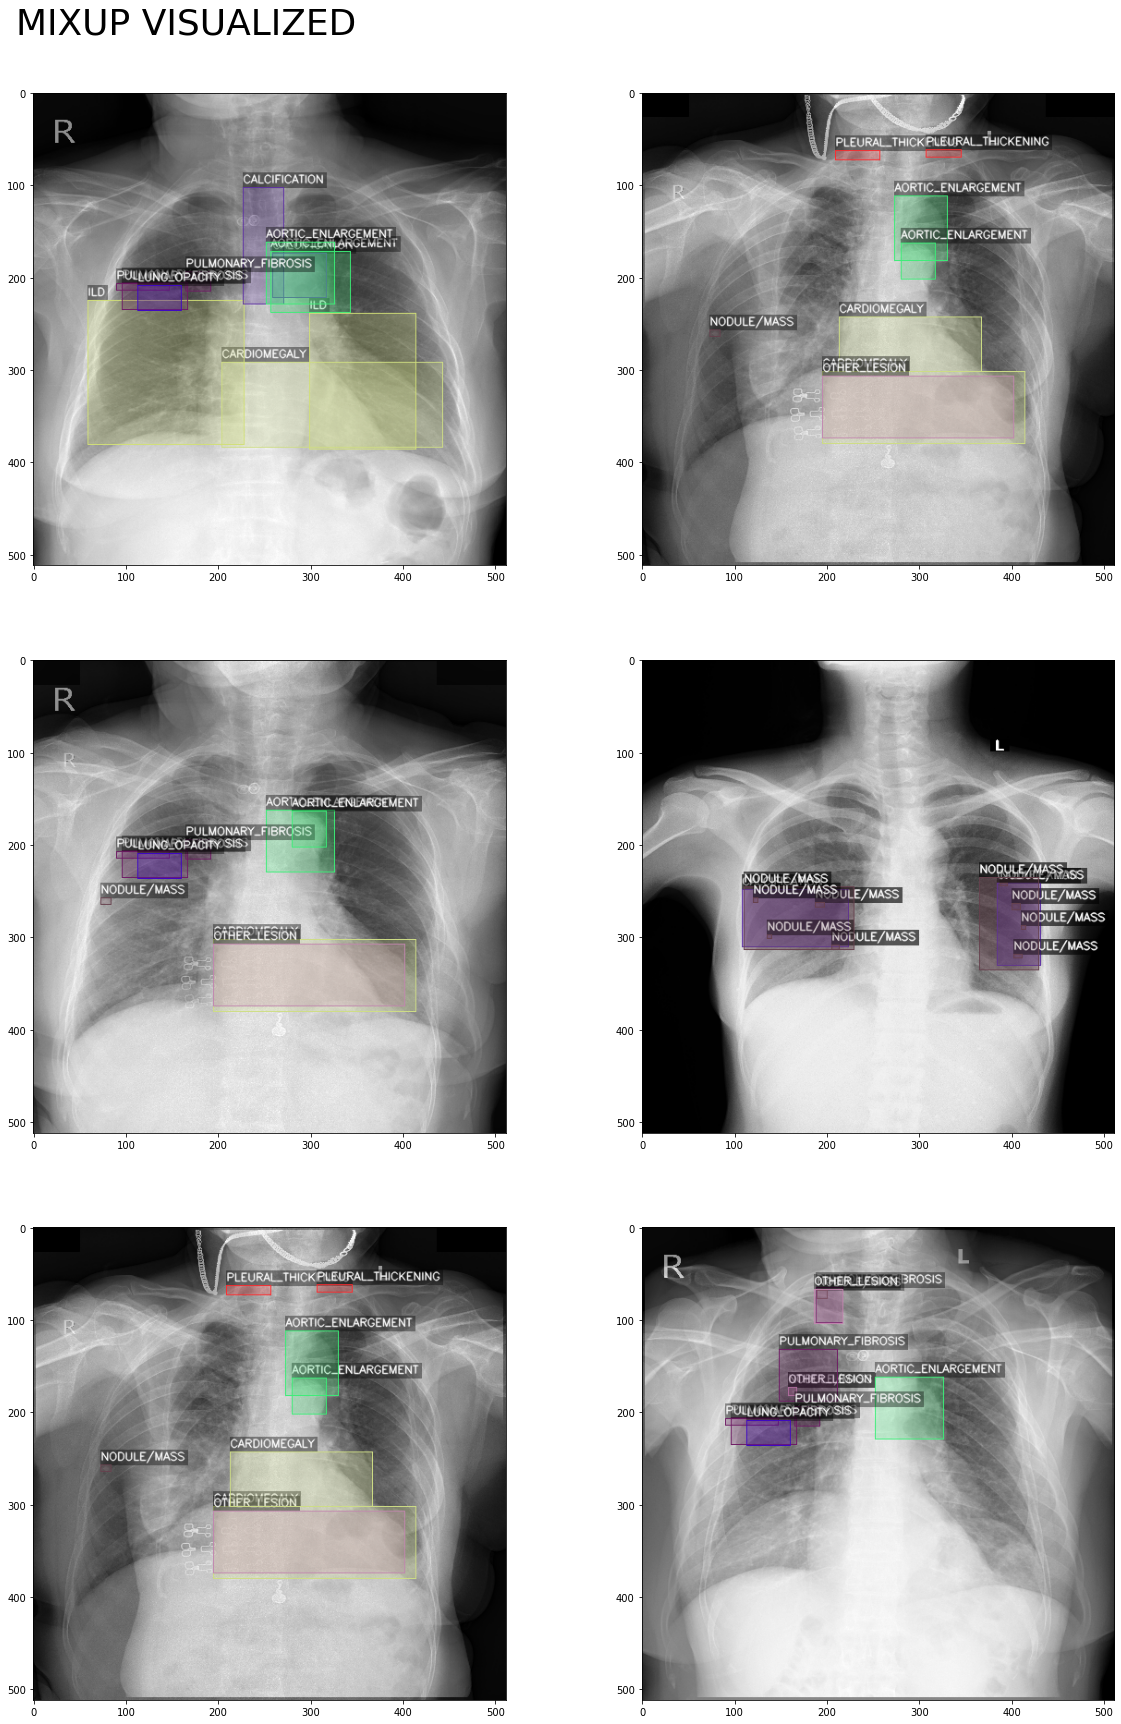

In [ ]:
warnings.filterwarnings("ignore")

viz_ids = df_annotations_wbf.sample(6).image_id.tolist()
viz_dataset = DatasetRetriever(
                    image_ids=np.array(viz_ids),
                    marking=df_annotations_wbf,
                    transforms=get_train_transforms(),
                    test=False,
                    )
viz_images = []
for idx, im_id in enumerate(viz_ids):
    image, boxes, labels = viz_dataset.load_mixup_image_and_boxes(idx)
    image_viz = image.copy()
#     print("image_viz.shape", image_viz.shape)
    for box, label in zip(boxes, labels):
        color = label2color[int(label)]
#         image_viz *= 255 
#         image_viz = image_viz.astype('uint8')
        image_viz = cv2.normalize(src=image_viz, dst=None, alpha=0, beta=255,
                                  norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        image_viz = draw_bbox_small(image_viz, list(np.int_(box)), viz_labels[label], color)
    viz_images.append(image_viz)

fig = plot_imgs(viz_images)
fig.suptitle("MIXUP VISUALIZED", x=0.125, y=0.91, ha='left',
             fontweight=100, fontfamily='Lato', size=36)
plt.savefig('mixup.png', bbox_inches='tight')
plt.show()

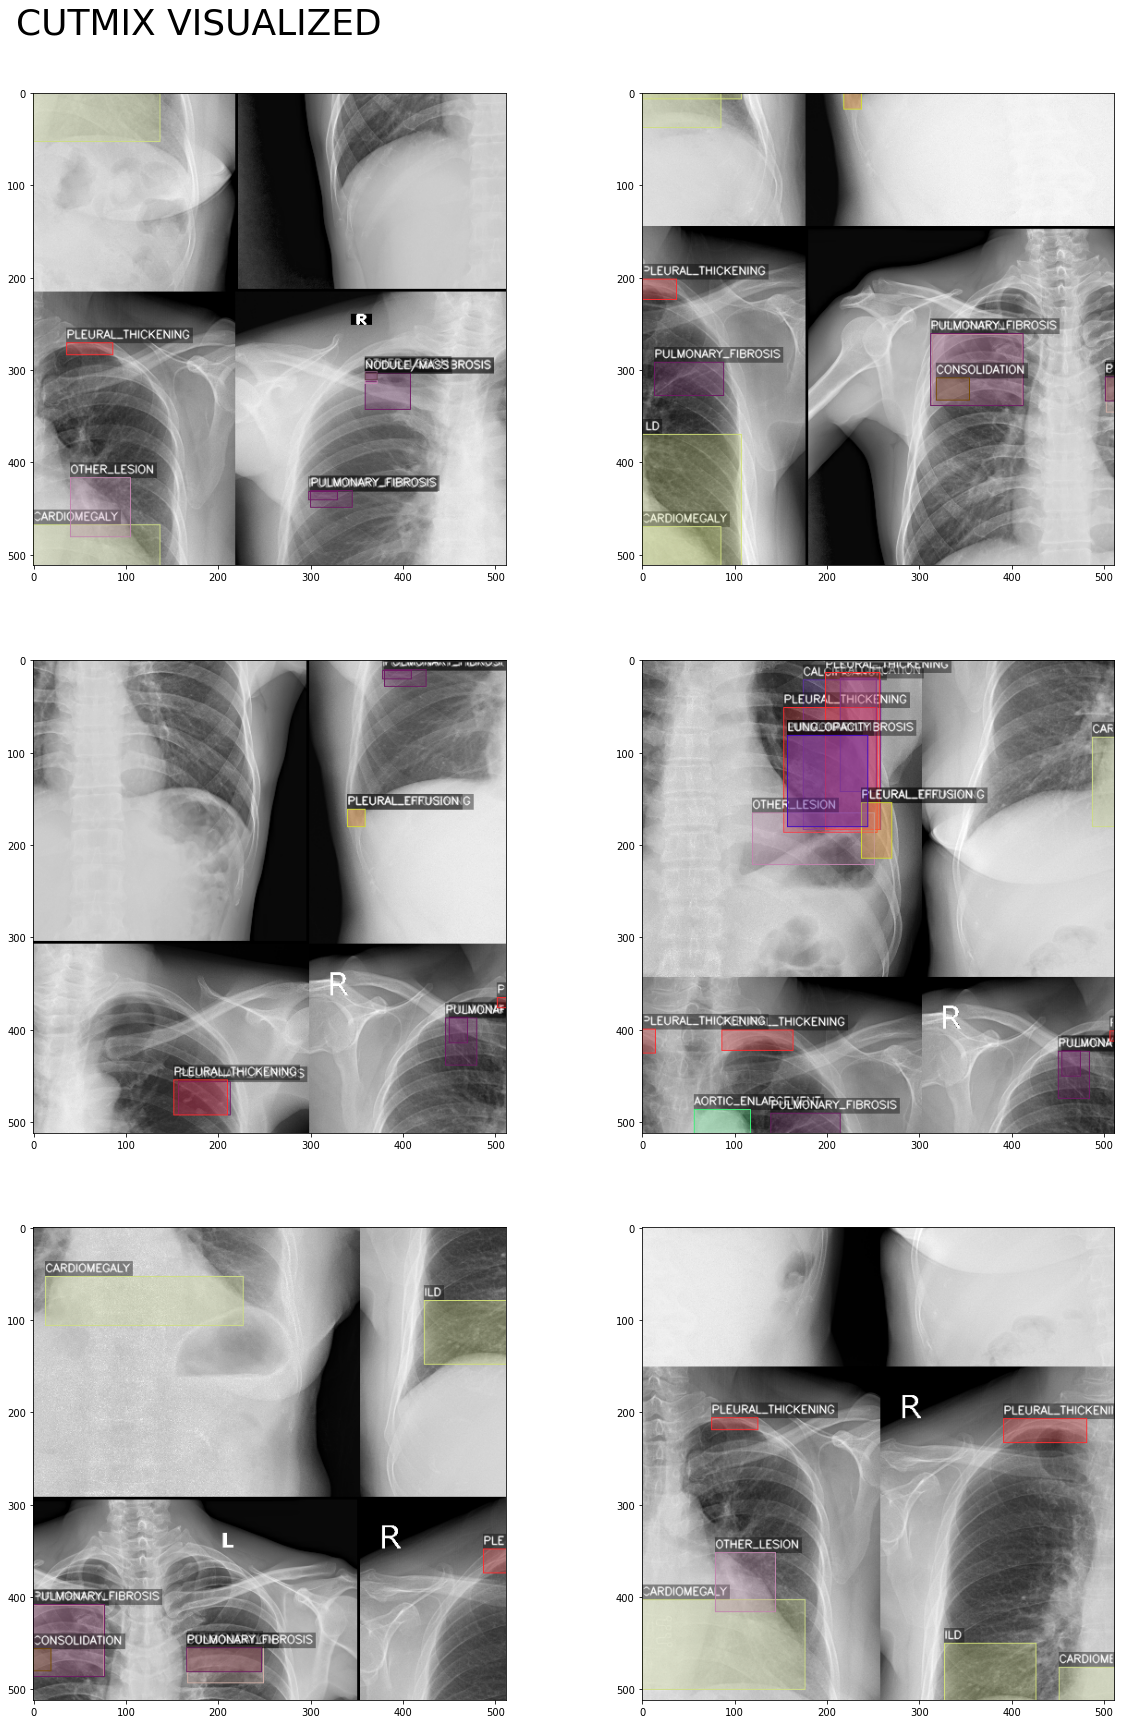

In [ ]:
viz_ids = df_annotations_wbf.sample(6).image_id.tolist()
viz_dataset = DatasetRetriever(
                    image_ids=np.array(viz_ids),
                    marking=df_annotations_wbf,
                    transforms=get_train_transforms(),
                    test=False,
                    )
viz_images = []
for idx, im_id in enumerate(viz_ids):
    image, boxes, labels = viz_dataset.load_cutmix_image_and_boxes(idx)
    image_viz = image.copy()
#     print("image_viz.shape", image_viz.shape)
    for box, label in zip(boxes, labels):
        color = label2color[int(label)]
#         image_viz *= 255 
#         image_viz = image_viz.astype('uint8')
        image_viz = cv2.normalize(src=image_viz, dst=None, alpha=0, beta=255,
                                  norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        image_viz = draw_bbox_small(image_viz, list(np.int_(box)), viz_labels[label], color)
    viz_images.append(image_viz)

fig = plot_imgs(viz_images)
fig.suptitle("CUTMIX VISUALIZED", x=0.125, y=0.91, ha='left',
             fontweight=100, fontfamily='Lato', size=36)
plt.savefig('cutmix.png', bbox_inches='tight')
plt.show()

# Build Training and Validation Loops

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
class Fitter:
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0

        self.base_dir = f'./{config.folder}'
        
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
        
        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10**5
        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ] 

        self.optimizer = config.OptimizerClass(self.model.parameters(), lr=config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')

    def fit(self, train_loader, validation_loader):
        history_dict = {}
        history_dict['epoch'] = []
        history_dict['train_loss'] = []
        history_dict['val_loss'] = []
        history_dict['train_lr'] = []
        
        for e in range(self.config.n_epochs):
            history_dict['epoch'].append(self.epoch)
            lr = self.optimizer.param_groups[0]['lr']
            timestamp = datetime.utcnow().isoformat()
            
            if self.config.verbose:
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss, loss_trend, lr_trend = self.train_epoch(train_loader)
            history_dict['train_loss'].append(loss_trend)
            history_dict['train_lr'].append(lr_trend)
            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')
            
            t = time.time()
            summary_loss, loss_trend = self.validation(validation_loader)
            history_dict['val_loss'].append(loss_trend)
            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
                self.model.eval()
                self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                
                try:
                    os.remove(f)
                except:pass
                f = f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin'

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)

            self.epoch += 1
        return history_dict

    def train_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        t = time.time()
        loss_trend = []
        lr_trend = []
        for step, (images, targets, image_ids) in tqdm(enumerate(train_loader), total=len(train_loader)):
            if self.config.verbose:
              print(
                  f'Train Step {step}/{len(train_loader)}, ' + \
                  f'summary_loss: {summary_loss.avg:.5f}, ' + \
                  f'time: {(time.time() - t):.5f}', end='\r'
              )            
        
            images = torch.stack(images)
            images = images.to(self.device).float()
            
            target_res = {}
            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]
            target_res['bbox'] = boxes
            target_res['cls'] = labels
            self.optimizer.zero_grad()
            output = self.model(images, target_res)

            loss = output['loss']
            loss.backward()
            summary_loss.update(loss.detach().item(), self.config.batch_size)
            self.optimizer.step()

            if self.config.step_scheduler:
                self.scheduler.step()

            
            lr = self.optimizer.param_groups[0]['lr']
            loss_trend.append(summary_loss.avg)
            lr_trend.append(lr)
        return summary_loss, loss_trend, lr_trend
    
    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        t = time.time()
        loss_trend = []
#         lr_trend = []
        
        for step, (images, targets, image_ids) in tqdm(enumerate(val_loader), total=len(val_loader)):
            if self.config.verbose:
                  print(
                      f'Val Step {step}/{len(val_loader)}, ' + \
                      f'summary_loss: {summary_loss.avg:.5f}, ' + \
                      f'time: {(time.time() - t):.5f}', end='\r'
                  )
            with torch.no_grad():
                images = torch.stack(images)
                images = images.to(self.device).float()
                target_res = {}
                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets]
                target_res['bbox'] = boxes
                target_res['cls'] = labels 
                target_res["img_scale"] = torch.tensor([1.0] * self.config.batch_size,
                                                       dtype=torch.float).to(self.device)
                target_res["img_size"] = torch.tensor([images[0].shape[-2:]] * self.config.batch_size,
                                                      dtype=torch.float).to(self.device)
                
                output = self.model(images, target_res)
            
                loss = output['loss']
                summary_loss.update(loss.detach().item(), self.config.batch_size)

                loss_trend.append(summary_loss.avg)
        return summary_loss, loss_trend[-1]
    
    
    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

## Define Training Configuration

In [ ]:
class TrainGlobalConfig:
    def __init__(self):
        self.num_classes = 14
        self.num_workers = 0
        self.batch_size = 4
        self.n_epochs = 15
        self.lr = 0.0002
        self.model_name = 'tf_efficientdet_d7'
        self.folder = 'training_job'
        self.verbose = True
        self.verbose_step = 1
        self.step_scheduler = True
        self.validation_scheduler = False
        self.n_img_count = len(df_annotations_wbf.image_id.unique())
        self.OptimizerClass = torch.optim.AdamW
        self.SchedulerClass = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts
        self.scheduler_params = dict(
                            T_0=50,
                            T_mult=1,
                            eta_min=0.0001,
                            last_epoch=-1,
                            verbose=False
                            )
        self.kfold = 1
    
    def reset(self):
        self.OptimizerClass = torch.optim.AdamW
        self.SchedulerClass = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts

train_config = TrainGlobalConfig()

## Creating Validation Folds

In [ ]:
from sklearn.model_selection import GroupKFold, train_test_split

df_annotations_wbf['fold'] = -1
group_kfold  = GroupKFold(n_splits = 3)
for fold, (train_index, val_index) in enumerate(group_kfold.split(df_annotations_wbf,
                                                              groups=df_annotations_wbf.image_id.tolist())):
    df_annotations_wbf.loc[val_index, 'fold'] = fold
df_annotations_wbf.sample(5)

image_id          class_name  ...  height  fold
5917   3df005a70ab162381374fd43655aa145                 ILD  ...    3072     1
15934  810491951571933b11959743e41a704b  Pulmonary_fibrosis  ...    2686     1
19876  354fc9f443af86eebc10e9b06a22481b        Other_lesion  ...    2695     0
21502  cfb0f1134227a67c3c30809e424fba01  Pleural_thickening  ...    2048     1
2324   1b90f72310730c8e045e85e8b60c308d  Aortic_enlargement  ...    3072     1

[5 rows x 11 columns]

# Initiate Training

In [ ]:
## Training will resume if the checkpoint path is specified below
checkpoint_path = None

device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

## Filters out invalid return items from the Dataloader
# def collate_fn(batch):
#     batch = list(filter(lambda x : x is not None, batch))
#     return default_collate(batch)

def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    
    return tuple(zip(*batch))

# def collate_fn(batch):
#     return tuple(zip(*batch))

fold_history = []
for val_fold in range(train_config.kfold):
    print(f'Fold {val_fold+1}/{train_config.kfold}')
    
    train_ids = df_annotations_wbf[df_annotations_wbf['fold'] != val_fold].image_id.unique()
    val_ids = df_annotations_wbf[df_annotations_wbf['fold'] == val_fold].image_id.unique()
    
    train_dataset = DatasetRetriever(
                        image_ids=train_ids,
                        marking=df_annotations_wbf,
                        transforms=get_train_transforms(),
                        test=False,
                        )

    validation_dataset = DatasetRetriever(
                            image_ids=val_ids,
                            marking=df_annotations_wbf,
                            transforms=get_valid_transforms(),
                            test=True,
                            )

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=train_config.batch_size,
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=True,
        num_workers=train_config.num_workers,
        collate_fn=collate_fn,
    )
    val_loader = torch.utils.data.DataLoader(
        validation_dataset, 
        batch_size=train_config.batch_size,
        num_workers=train_config.num_workers,
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
        collate_fn=collate_fn,
    )
    
    base_config = get_efficientdet_config(train_config.model_name)
    base_config.image_size = (512, 512)

    if(checkpoint_path):
        print(f'Resuming from checkpoint: {checkpoint_path}')        
        model = create_model_from_config(base_config, bench_task='train', bench_labeler=True,
                                 num_classes=train_config.num_classes,
                                 pretrained=False)
        model.to(device)
        
        fitter = Fitter(model=model, device=device, config=train_config)
        fitter.load(checkpoint_path)
    
    else:
        model = create_model_from_config(base_config, bench_task='train', bench_labeler=True,
                                     pretrained=True,
                                     num_classes=train_config.num_classes)
        model.to(device)
    
        fitter = Fitter(model=model, device=device, config=train_config)  
        
    model_config = model.config
    history_dict = fitter.fit(train_loader, val_loader)
    fold_history.append(history_dict)
    
    ## Reset Optimizer and LR Sch+)
    

Fold 1/1


Downloading: "https://github.com/rwightman/efficientdet-pytorch/releases/download/v0.1/tf_efficientdet_d7_53-6d1d7a95.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientdet_d7_53-6d1d7a95.pth


Fitter prepared. Device is cuda:0

2021-02-24T08:47:24.641601
LR: 0.0002



[RESULT]: Train. Epoch: 0, summary_loss: 1.01584, time: 1291.02975


Val Step 365/366, summary_loss: 0.82785, time: 383.28530
[RESULT]: Val. Epoch: 0, summary_loss: 0.82748, time: 383.41650

2021-02-24T09:15:23.264005
LR: 0.00012871103542174637



[RESULT]: Train. Epoch: 1, summary_loss: 0.86596, time: 1280.74945


Val Step 365/366, summary_loss: 0.77388, time: 363.81854
[RESULT]: Val. Epoch: 1, summary_loss: 0.77371, time: 363.94636

2021-02-24T09:42:52.468076
LR: 0.0001818711994874345



[RESULT]: Train. Epoch: 2, summary_loss: 0.83180, time: 1277.61901


Val Step 365/366, summary_loss: 0.74035, time: 370.83626
[RESULT]: Val. Epoch: 2, summary_loss: 0.74041, time: 370.96261

2021-02-24T10:10:25.812129
LR: 0.00010157084194356846



[RESULT]: Train. Epoch: 3, summary_loss: 0.81431, time: 1264.01517


Val Step 365/366, summary_loss: 0.74256, time: 367.00825
[RESULT]: Val. Epoch: 3, summary_loss: 0.74249, time: 367.13321

2021-02-24T10:37:39.242025
LR: 0.00014063093427071379



[RESULT]: Train. Epoch: 4, summary_loss: 0.78814, time: 1244.19047


Val Step 365/366, summary_loss: 0.72818, time: 359.41712
[RESULT]: Val. Epoch: 4, summary_loss: 0.72828, time: 359.54156

2021-02-24T11:04:27.508317
LR: 0.0001904508497187474



[RESULT]: Train. Epoch: 5, summary_loss: 0.78221, time: 1246.91823


Val Step 365/366, summary_loss: 0.70053, time: 352.54047
[RESULT]: Val. Epoch: 5, summary_loss: 0.70050, time: 352.66520

2021-02-24T11:31:11.638783
LR: 0.00010618466599780683



[RESULT]: Train. Epoch: 6, summary_loss: 0.77047, time: 1239.44742


Val Step 365/366, summary_loss: 0.72205, time: 356.83524
[RESULT]: Val. Epoch: 6, summary_loss: 0.72246, time: 356.95912

2021-02-24T11:57:50.326230
LR: 0.00015313952597646567



[RESULT]: Train. Epoch: 7, summary_loss: 0.75586, time: 1252.53668


Val Step 365/366, summary_loss: 0.68948, time: 366.38878
[RESULT]: Val. Epoch: 7, summary_loss: 0.68938, time: 366.51505

2021-02-24T12:24:53.669305
LR: 0.00019648882429441257



[RESULT]: Train. Epoch: 8, summary_loss: 0.74233, time: 1263.54780


Val Step 365/366, summary_loss: 0.69263, time: 368.35335
[RESULT]: Val. Epoch: 8, summary_loss: 0.69232, time: 368.47965

2021-02-24T12:52:08.100031
LR: 0.00011355156862892944



[RESULT]: Train. Epoch: 9, summary_loss: 0.73774, time: 1281.40727


Val Step 365/366, summary_loss: 0.67960, time: 367.15485
[RESULT]: Val. Epoch: 9, summary_loss: 0.67951, time: 367.28007

2021-02-24T13:19:41.218958
LR: 0.0001654508497187474



[RESULT]: Train. Epoch: 10, summary_loss: 0.73258, time: 1267.63699


Val Step 365/366, summary_loss: 0.67011, time: 367.41164
[RESULT]: Val. Epoch: 10, summary_loss: 0.66996, time: 367.54369

2021-02-24T13:47:00.989401
LR: 0.0001996057350657239



[RESULT]: Train. Epoch: 11, summary_loss: 0.72754, time: 1271.20763


Val Step 365/366, summary_loss: 0.66877, time: 365.36952
[RESULT]: Val. Epoch: 11, summary_loss: 0.66840, time: 365.49577

2021-02-24T14:14:22.226479
LR: 0.00012320866025105015



[RESULT]: Train. Epoch: 12, summary_loss: 0.72589, time: 1247.97157


Val Step 365/366, summary_loss: 0.68451, time: 348.30924
[RESULT]: Val. Epoch: 12, summary_loss: 0.68401, time: 348.43759

2021-02-24T14:41:00.921798
LR: 0.00017679133974894982



[RESULT]: Train. Epoch: 13, summary_loss: 0.71915, time: 1213.26309


Val Step 365/366, summary_loss: 0.66164, time: 347.60254
[RESULT]: Val. Epoch: 13, summary_loss: 0.66131, time: 347.72617

2021-02-24T15:07:06.515213
LR: 0.00010039426493427611



[RESULT]: Train. Epoch: 14, summary_loss: 0.70634, time: 1193.26080


Val Step 365/366, summary_loss: 0.68045, time: 348.95145
[RESULT]: Val. Epoch: 14, summary_loss: 0.67999, time: 349.07867


In [ ]:
!cp '/content/training_job/last-checkpoint.bin' '/content/drive/MyDrive/effDet/last-checkpoint.bin'

## Visualize Training Job & Model Metrics

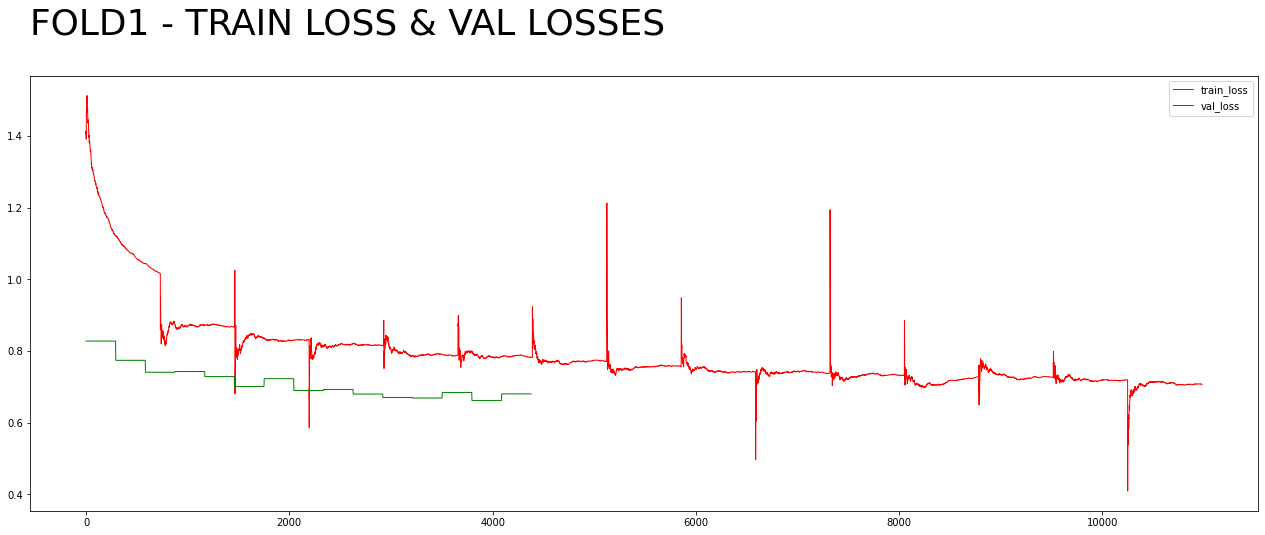

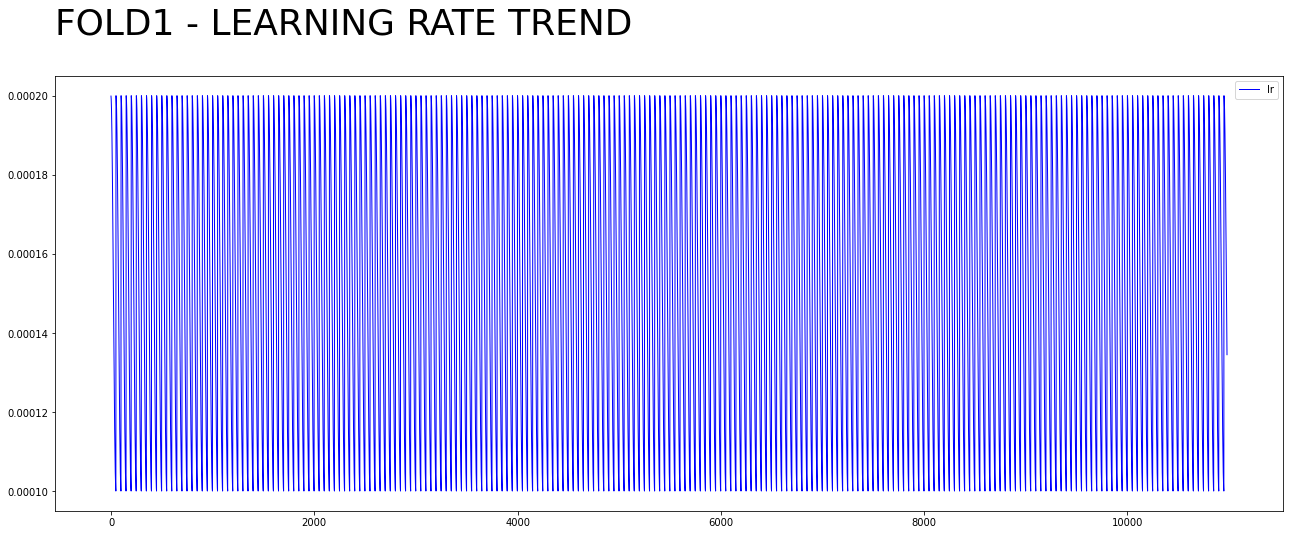

In [ ]:
fold_history_c = fold_history.copy()

train_loss_all = []
val_loss_all = []

n_steps_fold = (train_config.n_img_count//train_config.n_epochs)//train_config.kfold

for fold, fold_dict in enumerate(fold_history_c):
    train_losses = [item for sublist in fold_dict['train_loss'] for item in sublist]
    val_losses = [item for item in fold_dict['val_loss']]
    train_lrs = [item for sublist in fold_dict['train_lr'] for item in sublist]
    train_loss_all.append(np.array(train_losses))
    
    val_losses = np.repeat(val_losses, n_steps_fold).tolist()
    val_loss_all.append(np.array(val_losses))
    
    fig = plt.figure(figsize=(22,8))
    fig.suptitle(f'FOLD{fold+1} - TRAIN LOSS & VAL LOSSES', x=0.125, y=1.00, ha='left',
                 fontweight=100, fontfamily='Lato', size=36)
    plt.plot(train_losses, color='red', label='train_loss', linewidth=1)
    plt.plot(val_losses, color='green', label='val_loss', linewidth=1)
    plt.legend() 
    plt.savefig(f'fold{fold+1}_loss_trend.png', bbox_inches='tight')
    plt.show()
    
    fig = plt.figure(figsize=(22,8))
    fig.suptitle(f'FOLD{fold+1} - LEARNING RATE TREND', x=0.125, y=1.00, ha='left',
                 fontweight=100, fontfamily='Lato', size=36)
    plt.plot(train_lrs, color='blue', label='lr', linewidth=1)
    plt.legend() 
    plt.savefig(f'fold{fold+1}_lr_trend.png', bbox_inches='tight')
    plt.show()

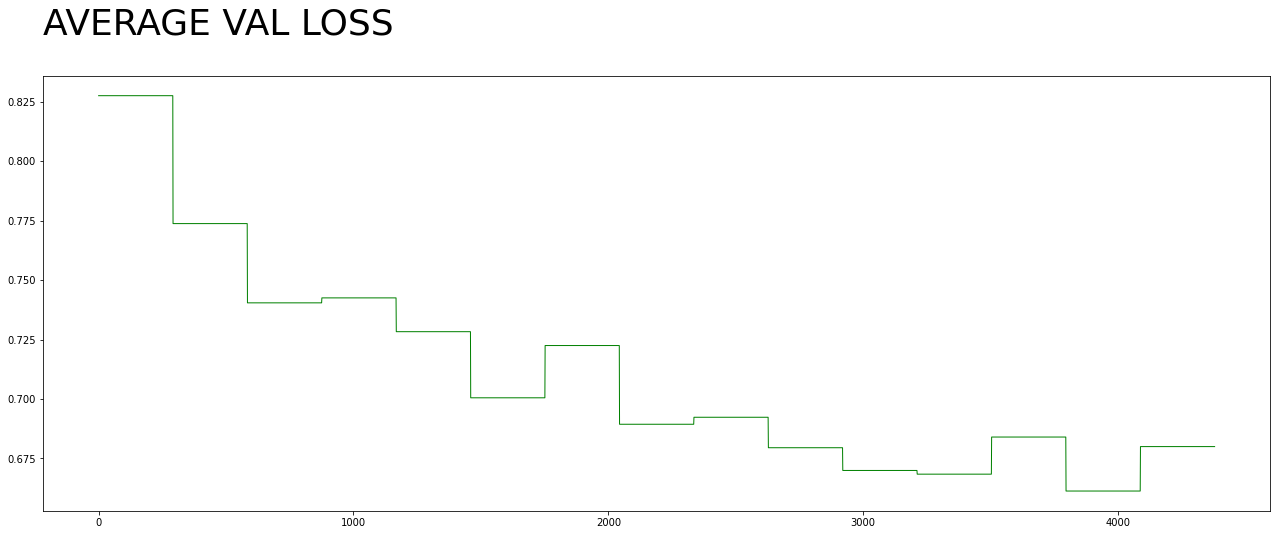

In [ ]:
train_df = pd.DataFrame([np.array(i) for i in train_loss_all]).transpose()
train_df['average'] = train_df.mean(axis=1)
val_df = pd.DataFrame([np.array(i) for i in val_loss_all]).transpose()
val_df['average'] = val_df.mean(axis=1)

fig = plt.figure(figsize=(22,8))
fig.suptitle(f'AVERAGE VAL LOSS', x=0.125, y=1.00, ha='left',
             fontweight=100, fontfamily='Lato', size=36)
# plt.plot(train_df['average'], color='red', label='train_loss', linewidth=1)
plt.plot(val_df['average'], color='green', label='val_loss', linewidth=1)
# plt.legend() 
# plt.savefig('avg_loss_trend.png', bbox_inches='tight')
plt.show()